In [2]:
import sys
import itertools
import json
from pprint import pprint
from typing import List

import clip  # type: ignore
import torch
import torch.nn.functional as F
import numpy as np
from scipy.stats import spearmanr, pearsonr

from datasets import AttributeDataset, ImageDataset, TextDataset, create_dataloader
from models import Linear
from trainer import run_one_epoch
from utils import computing_subgroup_metrics, subgrouping
from matplotlib import pyplot as plt
from utils import openai_imagenet_template, openai_imagenet_classes
from collections import defaultdict


CLIP_MODEL = "ViT-B/32"
LINEAR_MODEL = "dspites_linear_model.pt"
N_CLASS = 3
clip_model, transform = clip.load(name=CLIP_MODEL, device="cuda")
clip_model = clip_model.float()
model = Linear(clip_model.visual.output_dim, N_CLASS).cuda()
state_dict = torch.load(LINEAR_MODEL)
model.load_state_dict(state_dict)

<All keys matched successfully>

# Slice Analysis

## [Preparation] Ground-truth image dataset and text cross-product performance

In [21]:
image_data = [
    json.loads(line)
    for line in open("data/dSpites/processed_attribute_dataset/attributes.jsonl")
]
train_idxs, val_idxs = json.load(open("mmdebug/src/train_val_idxs.json"))
image_data = [x for i, x in enumerate(image_data) if i in val_idxs]

image_dataset = ImageDataset(data=image_data)
image_dataloader = create_dataloader(
    dataset=image_dataset, modality="image", transform=transform
)
image_metrics = run_one_epoch(
    dataloader=image_dataloader,
    model=model,
    clip_model=clip_model,
    modality="image",
    opt=None,
    epoch_idx=-1,
    eval=True,
    verbose=True,
)

# Dataset attributes
attributes = {
    "color": set([x["attributes"]["color"] for x in image_data]),
    # "position": set([x["attributes"]["position"] for x in image_data]),
    "label": set([x["attributes"]["label"] for x in image_data]),
    "scale": set([x["attributes"]["scale"] for x in image_data]),
}
attributes_combinations = [
    dict(zip(attributes, x)) for x in itertools.product(*attributes.values())
]

label_mapping = {"triangle": 0, "square": 1, "circle": 2}


################################ Raw ################################
text_data = [
    {
        "text": f"{['small', 'medium', 'large'][int(x['scale'] * 2 - 1)]}, {x['color']}, {x['label']}.",
        "label": label_mapping[x["label"]],
        "attributes": {
            "color": x["color"],
            # "position": x["position"],
            "label": x["label"],
            "scale": x["scale"],
        },
    }
    for x in attributes_combinations
]

################################ Prompt Engineering ################################
# text_data = [
#     {
#         "text": f"{['small', 'medium', 'large'][int(x['scale'] * 2 - 1)]} {x['color']} {x['label']}.",  # {['upper left', 'lower left', 'upper right', 'lower right'][x['position']]}.",
#         "label": label_mapping[x["label"]],
#         "attributes": {
#             "color": x["color"],
#             # "position": x["position"],
#             "label": x["label"],
#             "scale": x["scale"],
#         },
#     }
#     for x in attributes_combinations
# ]

################################ Prompt Ensemble ################################
# text_data = [
#     {
#         "text": prompt(f"{['small', 'medium', 'large'][x['concrete_scale']]} {x['color']} {['square', 'triangle'][x['label']]}"), # {['upper left', 'lower left', 'upper right', 'lower right'][x['position']]}.",
#         "label": x["label"],
#         "attributes": {
#             "color": x["color"],
#             # "position": x["position"],
#             "label": x["label"],
#             "concrete_scale": x["concrete_scale"],
#         },
#     }
#     for x in attributes_combinations
#     for prompt in openai_imagenet_template
# ]

# TODO: select one from above

text_dataset = TextDataset(data=text_data)
text_dataloader = create_dataloader(dataset=text_dataset, modality="text")
text_metrics = run_one_epoch(
    dataloader=text_dataloader,
    model=model,
    clip_model=clip_model,
    modality="text",
    opt=None,
    epoch_idx=-1,
    eval=True,
    verbose=True,
)

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "develop/miniconda3/envs/dalle/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "develop/miniconda3/envs/dalle/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self._close()
  File "develop/miniconda3/envs/dalle/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "develop/miniconda3/envs/dalle/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "develop/miniconda3/envs/dalle/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "develop/miniconda3/envs/dalle/lib/python3.8/multiprocessing/queues.py", line 266, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times
Ep

In [15]:
attributes

{'color': {'blue',
  'brown',
  'cyan',
  'green',
  'orange',
  'pink',
  'purple',
  'red',
  'violet',
  'yellow'},
 'label': {'circle', 'square', 'triangle'},
 'scale': {0.5, 1.0, 1.5}}

## Larger slice discovery

In [22]:
fields = ["color", "label"]

image_preds, image_labels = image_metrics["preds"], image_metrics["labels"]
image_subgroups = subgrouping(image_data, fields)
image_subgroup_metrics = computing_subgroup_metrics(
    image_preds, image_labels, image_subgroups
)
pprint(sorted(image_subgroup_metrics.items(), key=lambda x: x[1])[:5])
print()

text_preds, text_labels = text_metrics["preds"], text_metrics["labels"]
text_subgroups = subgrouping(text_data, fields)
text_subgroup_metrics = computing_subgroup_metrics(
    text_preds, text_labels, text_subgroups
)
pprint(sorted(text_subgroup_metrics.items(), key=lambda x: x[1])[:5])
print()

text_logits = text_metrics["logits"]
text_probs = torch.softmax(torch.tensor(text_logits), dim=1).numpy().tolist()
text_subgroup_probs = defaultdict(list)
for i, x in enumerate(text_data):
    key = (("color", x["attributes"]["color"]), ("label", x["attributes"]["label"]))
    value = text_probs[i][x["label"]]
    text_subgroup_probs[key].append(value)
text_subgroup_probs = {k: float(np.mean(v)) for k, v in text_subgroup_probs.items()}
pprint(sorted(text_subgroup_probs.items(), key=lambda x: x[1])[:5])
print()

[((('color', 'orange'), ('label', 'square')), 0.7687687687687688),
 ((('color', 'brown'), ('label', 'square')), 0.8404558404558404),
 ((('color', 'purple'), ('label', 'square')), 0.9171597633136095),
 ((('color', 'cyan'), ('label', 'square')), 0.9590643274853801),
 ((('color', 'pink'), ('label', 'triangle')), 0.984472049689441)]

[((('color', 'blue'), ('label', 'circle')), 1.0),
 ((('color', 'blue'), ('label', 'square')), 1.0),
 ((('color', 'blue'), ('label', 'triangle')), 1.0),
 ((('color', 'brown'), ('label', 'circle')), 1.0),
 ((('color', 'brown'), ('label', 'square')), 1.0)]

[((('color', 'brown'), ('label', 'circle')), 0.4646821816762288),
 ((('color', 'violet'), ('label', 'circle')), 0.519475390513738),
 ((('color', 'orange'), ('label', 'square')), 0.519541064898173),
 ((('color', 'red'), ('label', 'circle')), 0.5217217206954956),
 ((('color', 'purple'), ('label', 'circle')), 0.5474876960118612)]



## Atomic slice correlation

In [4]:
def compute_correlation(data1_list: List, data2_list: List) -> None:
    assert len(data1_list) == len(data2_list)
    data1 = np.array(data1_list)
    data2 = np.array(data2_list)
    spearmanr_corr, spearmanr_pval = spearmanr(data1, data2)
    pearsonr_corr, pearsonr_pval = pearsonr(data1, data2)
    print(f"Spearman correlation: {spearmanr_corr:.4f} (p-value: {spearmanr_pval:.4f})")
    print(f"Pearson correlation: {pearsonr_corr:.4f} (p-value: {pearsonr_pval:.4f})")
    plt.figure()
    plt.scatter(data1, data2, alpha=0.3, s=10)
    plt.show()

Spearman correlation: nan (p-value: nan)
Pearson correlation: nan (p-value: nan)


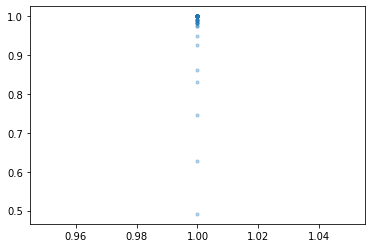

Spearman correlation: -0.1025 (p-value: 0.3365)
Pearson correlation: 0.0605 (p-value: 0.5712)


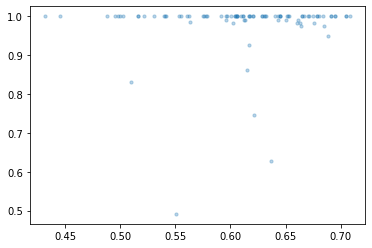

In [24]:
fields = ["color", "label", "scale"]

image_preds, image_labels = image_metrics["preds"], image_metrics["labels"]
image_subgroups = subgrouping(image_data, fields)
image_subgroup_metrics = computing_subgroup_metrics(
    image_preds, image_labels, image_subgroups
)
# pprint(sorted(image_subgroup_metrics.items(), key=lambda x: x[1])[:3])
# print()

text_preds, text_labels = text_metrics["preds"], text_metrics["labels"]
text_subgroups = subgrouping(text_data, fields)
text_subgroup_metrics = computing_subgroup_metrics(
    text_preds, text_labels, text_subgroups
)
# pprint(sorted(text_subgroup_metrics.items(), key=lambda x: x[1])[:3])
# print()

text_logits = text_metrics["logits"]
text_probs = torch.softmax(torch.tensor(text_logits), dim=1).numpy().tolist()
text_subgroup_probs = defaultdict(list)
for i, x in enumerate(text_data):
    key = (
        ("color", x["attributes"]["color"]),
        ("label", x["attributes"]["label"]),
        # ("position", x["attributes"]["position"]),
        ("scale", x["attributes"]["scale"]),
    )
    value = text_probs[i][x["label"]]
    text_subgroup_probs[key].append(value)
text_subgroup_probs = {k: float(np.mean(v)) for k, v in text_subgroup_probs.items()}
# pprint(sorted(text_subgroup_probs.items(), key=lambda x: x[1])[:3])
# print()

compute_correlation(
    [text_subgroup_metrics[x] for x in image_subgroup_metrics],
    [image_subgroup_metrics[x] for x in image_subgroup_metrics],
)
compute_correlation(
    [text_subgroup_probs[x] for x in image_subgroup_metrics],
    [image_subgroup_metrics[x] for x in image_subgroup_metrics],
)

## Image Correlation Analysis

Epoch -1, Eval True: 100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.07it/s]

[((('age', '0-2'), ('race', 'Black'), ('gender', 'Female')), 0.0),
 ((('age', '0-2'), ('race', 'Middle Eastern'), ('gender', 'Female')), 0.0),
 ((('age', '3-9'), ('race', 'Black'), ('gender', 'Male')), 0.0)]

[((('age', '20-29'), ('race', 'Middle Eastern'), ('gender', 'Male')),
  0.00465531786903739),
 ((('age', '40-49'), ('race', 'East Asian'), ('gender', 'Female')),
  0.0048574176616966724),
 ((('age', '60-69'), ('race', 'Latino_Hispanic'), ('gender', 'Female')),
  0.006033725570887327)]

Spearman correlation: 0.0954 (p-value: 0.2879)
Pearson correlation: 0.3158 (p-value: 0.0003)


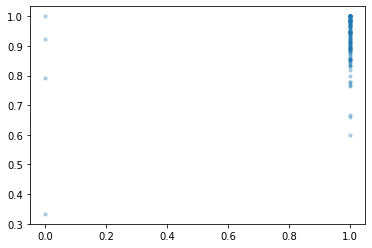

Spearman correlation: -0.0658 (p-value: 0.4643)
Pearson correlation: 0.0393 (p-value: 0.6619)


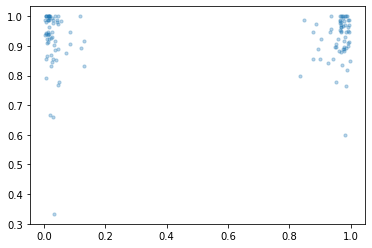

In [16]:
# fields = ["color", "label", "concrete_scale"]


# image_generated_data = [
#     json.loads(line)
#     for line in open(
#         "fairface/fairface_text_data_generated_images.jsonl"
#     )
# ]

# for item in image_generated_data:
#     item["image"] = item["image"].replace(
#         "", ""
#     )
#     if item["attributes"]["race"] == "Latino Hispanic":
#         item["attributes"]["race"] = "Latino_Hispanic"


# def filter_fn(x):
#     return True


# image_generated_data = [x for x in image_generated_data if filter_fn(x)]


# def label_fn(x):
#     return 1 if x["attributes"]["gender"] == "Female" else 0


# for item in image_generated_data:
#     item["label"] = label_fn(item)

# image_generated_dataset = ImageDataset(data=image_generated_data)
# image_generated_dataloader = create_dataloader(
#     dataset=image_generated_dataset, modality="image", transform=transform
# )
# image_generated_metrics = run_one_epoch(
#     dataloader=image_generated_dataloader,
#     model=model,
#     clip_model=clip_model,
#     modality="image",
#     opt=None,
#     epoch_idx=-1,
#     eval=True,
#     verbose=True,
# )
# image_generated_preds, image_generated_labels = (
#     image_generated_metrics["preds"],
#     image_generated_metrics["labels"],
# )
# image_generated_subgroups = subgrouping(image_generated_data, fields)
# image_generated_subgroup_metrics = computing_subgroup_metrics(
#     image_generated_preds, image_generated_labels, image_generated_subgroups
# )
# pprint(sorted(image_generated_subgroup_metrics.items(), key=lambda x: x[1])[:3])
# print()

# image_generated_logits = image_generated_metrics["logits"]
# image_generated_probs = (
#     torch.softmax(torch.tensor(image_generated_logits), dim=1).numpy().tolist()
# )
# image_generated_subgroup_probs = defaultdict(list)
# for i, x in enumerate(image_generated_data):
#     key = (
#         ("age", x["attributes"]["age"]),
#         ("race", x["attributes"]["race"]),
#         ("gender", x["attributes"]["gender"]),
#     )
#     value = text_probs[i][x["label"]]
#     image_generated_subgroup_probs[key].append(value)
# image_generated_subgroup_probs = {
#     # k: v[0] for k, v in image_generated_subgroup_probs.items()
#     k: float(np.mean(v))
#     for k, v in image_generated_subgroup_probs.items()  # 1 image correlation
# }
# pprint(sorted(image_generated_subgroup_probs.items(), key=lambda x: x[1])[:3])
# print()

# compute_correlation(
#     [image_generated_subgroup_metrics[x] for x in image_subgroup_metrics],
#     [image_subgroup_metrics[x] for x in image_subgroup_metrics],
# )  # Accuracy-Accuracy Correlation
# compute_correlation(
#     [image_generated_subgroup_probs[x] for x in image_subgroup_metrics],
#     [image_subgroup_metrics[x] for x in image_subgroup_metrics],
# )  # Prob-Accuracy Correlation

# Attribute-based Interpretation

In [98]:
attributes = {
    "scale": {"small", "medium", "large"},
    "color": {"blue", "cyan", "green", "orange", "pink", "red"},
}

## Direct influence

In [99]:
attribute_list = list(attributes["color"])

attribute_embeddings = F.normalize(
    clip_model.encode_text(clip.tokenize(attribute_list).cuda())
)
probs = torch.softmax(model(attribute_embeddings), dim=1)

attribute_scores = {
    attribute_list[i]: float(probs[i, 1]) for i in range(len(attribute_list))
}

print("If we care about triangle (label = 1), the most similar attributes are:")
print(sorted(attribute_scores.items(), key=lambda x: x[1], reverse=True)[:10])

If we care about triangle (label = 1), the most similar attributes are:
[('orange', 0.8680298924446106), ('red', 0.4075278043746948), ('pink', 0.3324088752269745), ('cyan', 0.32082444429397583), ('blue', 0.2729652225971222), ('green', 0.06301457434892654)]


## Aggregated Influence: Shapley Value s(a) = E_{S subset {F \ a}} [f(S, a) - f(S)]

In [100]:
scale_list = list(attributes["scale"])
color_list = list(attributes["color"])

attribute_shapley = {}
print(
    "If we care about triangle (label = 1), the most influential attributes are (reported Shapley value):"
)
for scale in scale_list:
    prompts = (
        [f"a {color} square." for color in color_list]
        + [f"a {color} triangle." for color in color_list]
        + [f"a {scale} {color} square." for color in color_list]
        + [f"a {scale} {color} triangle." for color in color_list]
    )
    with torch.no_grad():
        inputs = clip.tokenize(prompts).cuda()
        embeddings = F.normalize(clip_model.encode_text(inputs))
        probs = torch.softmax(model(embeddings), dim=1).cpu()

    shapley = (probs[len(color_list) * 2 :, 1] - probs[: 2 * len(color_list), 1]).mean()
    attribute_shapley[scale] = shapley

pprint(sorted(attribute_shapley.items(), key=lambda x: x[1], reverse=True)[:10])

If we care about triangle (label = 1), the most influential attributes are (reported Shapley value):
[('large', tensor(-0.0081)),
 ('small', tensor(-0.0188)),
 ('medium', tensor(-0.0250))]


In [102]:
scale_list = list(attributes["scale"])
color_list = list(attributes["color"])

attribute_shapley = {}
print(
    "If we care about triangle (label = 1), the most influential attributes are (reported Shapley value):"
)
for color in color_list:
    prompts = (
        [f"a {scale} square." for scale in scale_list]
        + [f"a {scale} triangle." for scale in scale_list]
        + [f"a {scale} {color} square." for scale in scale_list]
        + [f"a {scale} {color} triangle." for scale in scale_list]
    )
    with torch.no_grad():
        inputs = clip.tokenize(prompts).cuda()
        embeddings = F.normalize(clip_model.encode_text(inputs))
        probs = torch.softmax(model(embeddings), dim=1).cpu()

    shapley = (probs[len(scale_list) * 2 :, 1] - probs[: 2 * len(scale_list), 1]).mean()
    attribute_shapley[color] = shapley

pprint(sorted(attribute_shapley.items(), key=lambda x: x[1], reverse=True)[:10])

If we care about triangle (label = 1), the most influential attributes are (reported Shapley value):
[('orange', tensor(0.3736)),
 ('red', tensor(-0.0470)),
 ('blue', tensor(-0.0784)),
 ('cyan', tensor(-0.0979)),
 ('pink', tensor(-0.1181)),
 ('green', tensor(-0.3321))]
